# Problem Statement

OList is an e-commerce company that has recently faced some losses and wants to manage its inventory more effectively to reduce unnecessary costs. 

In this assignment, we will manage the inventory costs for OList by identifying the top products that contribute to revenue. Additionally, we will use market basket analysis to examine the purchase behavior of individual customers, helping us estimate with relative certainty which items are more likely to be purchased individually or in combination with other products.

### Importing the libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

### Importing the Dataset

In [3]:
# Reading the application_data csv file

orders_df = pd.read_excel(r'C:\Users\subhasish\Desktop\Subhasish\Upgrad\Capstone Project\Retail_dataset.xlsx', sheet_name = 'orders')
order_items_df = pd.read_excel(r'C:\Users\subhasish\Desktop\Subhasish\Upgrad\Capstone Project\Retail_dataset.xlsx', sheet_name = 'order_items')
customers_df = pd.read_excel(r'C:\Users\subhasish\Desktop\Subhasish\Upgrad\Capstone Project\Retail_dataset.xlsx', sheet_name = 'customers')
payments_df = pd.read_excel(r'C:\Users\subhasish\Desktop\Subhasish\Upgrad\Capstone Project\Retail_dataset.xlsx', sheet_name = 'payments')
products_df = pd.read_excel(r'C:\Users\subhasish\Desktop\Subhasish\Upgrad\Capstone Project\Retail_dataset.xlsx', sheet_name = 'products')

### Data Set Exploration and Cleaning

#### a. Dataset orders_df

In [4]:
# Read Order dataframe
orders_df.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_timestamp,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,7c396fd4830fd04220f754e42b4e5bff,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-10 21:25:13,2017-10-18
1,53cdb2fc8bc7dce0b6741e2150273451,af07308b275d755c9edb36a90c618231,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-08-07 15:27:45,2018-08-13
2,47770eb9100c2d0c44946d9cf07ec65d,3a653a41f6f9fc3d2a113cf8398680e8,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-17 18:06:29,2018-09-04
3,949d5b44dbf5de918fe9c16f97b45f8a,7c142cf63193a1473d2e66489a9ae977,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-12-02 00:28:42,2017-12-15
4,ad21c59c0840e6cb83a9ceb5573f8159,72632f0f9dd73dfee390c9b22eb56dd6,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-16 18:17:02,2018-02-26


In [5]:
# Check column info
orders_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 7 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       99441 non-null  object        
 1   customer_id                    99441 non-null  object        
 2   order_status                   99441 non-null  object        
 3   order_purchase_timestamp       99441 non-null  datetime64[ns]
 4   order_approved_at              99281 non-null  datetime64[ns]
 5   order_delivered_timestamp      96476 non-null  datetime64[ns]
 6   order_estimated_delivery_date  99441 non-null  datetime64[ns]
dtypes: datetime64[ns](4), object(3)
memory usage: 5.3+ MB


In [6]:
# Check for any missing value
orders_df.isnull().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_timestamp        2965
order_estimated_delivery_date       0
dtype: int64

In [7]:
# Check the order status field

orders_df.order_status.value_counts(normalize = True) * 100

order_status
delivered      97.020344
shipped         1.113223
canceled        0.628513
unavailable     0.612423
invoiced        0.315765
processing      0.302692
created         0.005028
approved        0.002011
Name: proportion, dtype: float64

97% of the records have a status of "delivered," we will focus only on orders that have been successfully delivered for this case study.

In [8]:
# Keeping only delivered order_status

orders_df = orders_df[orders_df.order_status == 'delivered']

In [9]:
# Check the order status again
orders_df.order_status.value_counts(normalize = True) * 100

order_status
delivered    100.0
Name: proportion, dtype: float64

We are going to analyze the orders_df dataset with only delivered products

In [10]:
# Check for any missing value again, since we are analyzing the products which were delivered.
orders_df.isnull().sum()

order_id                          0
customer_id                       0
order_status                      0
order_purchase_timestamp          0
order_approved_at                14
order_delivered_timestamp         8
order_estimated_delivery_date     0
dtype: int64

The dataset contains missing values for order_approved_at and order_delivered_timestamp. It is evident that the order approval time is the same as the order purchase timestamp, and we can assume that the order delivery timestamp should match the order estimated delivery date.

In [11]:
# Replace the missing value for order_approved_at.
orders_df.order_approved_at.fillna(orders_df.order_purchase_timestamp, inplace=True)

In [12]:
# Replace the missing value for order_delivered_timestamp.
orders_df.order_delivered_timestamp.fillna(orders_df.order_estimated_delivery_date, inplace=True)

In [13]:
# Checking the missing value again
orders_df.isnull().sum()

order_id                         0
customer_id                      0
order_status                     0
order_purchase_timestamp         0
order_approved_at                0
order_delivered_timestamp        0
order_estimated_delivery_date    0
dtype: int64

In [14]:
orders_df.describe()

,order_purchase_timestamp,order_approved_at,order_delivered_timestamp,order_estimated_delivery_date
count,96478,96478,96478,96478
mean,2018-01-01 23:29:31.939913984,2018-01-02 09:46:02.932585728,2018-01-14 12:54:42.346493696,2018-01-25 17:09:52.325711616
min,2016-09-15 12:16:38,2016-09-15 12:16:38,2016-10-11 13:46:32,2016-10-04 00:00:00
25%,2017-09-14 09:00:23.249999872,2017-09-14 13:30:21.249999872,2017-09-25 22:18:14.500000,2017-10-05 00:00:00
50%,2018-01-20 19:45:45,2018-01-22 13:48:43.500000,2018-02-02 19:41:06,2018-02-16 00:00:00
75%,2018-05-05 18:54:47,2018-05-06 10:52:59.249999872,2018-05-15 23:09:25.750000128,2018-05-28 00:00:00
max,2018-08-29 15:00:37,2018-08-29 15:10:26,2018-10-17 13:22:46,2018-10-25 00:00:00


#### b. Dataset order_items_df

In [15]:
# Read Order item dataframe
order_items_df.head()

,order_id,order_item_id,product_id,seller_id,price,shipping_charges
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,199.90,18.14


In [16]:
# Check column info
order_items_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   order_id          112650 non-null  object 
 1   order_item_id     112650 non-null  int64  
 2   product_id        112650 non-null  object 
 3   seller_id         112650 non-null  object 
 4   price             112650 non-null  float64
 5   shipping_charges  112650 non-null  float64
dtypes: float64(2), int64(1), object(3)
memory usage: 5.2+ MB


In [17]:
# Check for any missing value
order_items_df.isnull().sum()

order_id            0
order_item_id       0
product_id          0
seller_id           0
price               0
shipping_charges    0
dtype: int64

In [18]:
# Check for any duplicates
order_items_df.duplicated().sum()

0

No duplicate value is present in order_items_df dataset

#### c. Dataset customers_df

In [19]:
# Read customer dataframe
customers_df.head()

,customer_id,customer_zip_code_prefix,customer_city,customer_state
0,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [20]:
# Check column info
customers_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 4 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_zip_code_prefix  99441 non-null  int64 
 2   customer_city             99441 non-null  object
 3   customer_state            99441 non-null  object
dtypes: int64(1), object(3)
memory usage: 3.0+ MB


In [21]:
# Check for any missing value
customers_df.isnull().sum()

customer_id                 0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

In [22]:
# Check for duplicate vaiue
customers_df.duplicated().sum()

3089

In [23]:
# Check for 3089 duplicate values
customers_df[customers_df.customer_id.duplicated()]

,customer_id,customer_zip_code_prefix,customer_city,customer_state
679,b6c083700ca8c135ba9f0f132930d4e8,8686,suzano,SP
1463,a40096fc0a3862e9e12bc55b5f8e6ab2,20561,rio de janeiro,RJ
1607,b8b3c435a58aebd788a477bed8342910,95585,arroio do sal,RS
2811,66980c3775537536f77b434d74e520f5,30290,belo horizonte,MG
3198,788313d21c3507fe890921f6e17aa679,11070,santos,SP
...,...,...,...,...
99324,8bab3162259edfaadd1ea2e1fe7f58dc,31565,belo horizonte,MG
99327,12ab9334b1240d6d037f2b0102a49571,38050,uberaba,MG
99336,0ee57f62666561b72f2ceacad0230cbf,9530,sao caetano do sul,SP
99353,0ceb502fc33a2ad327b08288c5310e2e,29134,viana,ES


There is 3345 rows with duplicate values.
To remove duplicate records, we will retain only the first occurrence of each value and drop the remaining duplicates.

In [24]:
# Drop duplicate customer ids, keep only the first occurance

customers_df.drop_duplicates(subset="customer_id", keep="first", inplace=True)

In [25]:
# Check again for any duplicate value
customers_df.duplicated().sum()

0

No more duplicate values are present the customer dataframe

In [27]:
# Check the shape of the data
customers_df.shape

(96096, 4)

Initially, there were 99,441 entries. After removing the duplicate entries, 96,096 entries remain

#### d. Dataset payments_df

In [28]:
# Read payments dataframe
payments_df.head()

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45


In [29]:
# Check column info
payments_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103886 entries, 0 to 103885
Data columns (total 5 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   order_id              103886 non-null  object 
 1   payment_sequential    103886 non-null  int64  
 2   payment_type          103886 non-null  object 
 3   payment_installments  103886 non-null  int64  
 4   payment_value         103886 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 4.0+ MB


In [30]:
# Check for any missing value
payments_df.isnull().sum()

order_id                0
payment_sequential      0
payment_type            0
payment_installments    0
payment_value           0
dtype: int64

In [31]:
# Check for duplicate vaiue
payments_df.duplicated().sum()

0

No missing value and duplicate value is there in payment dataframe

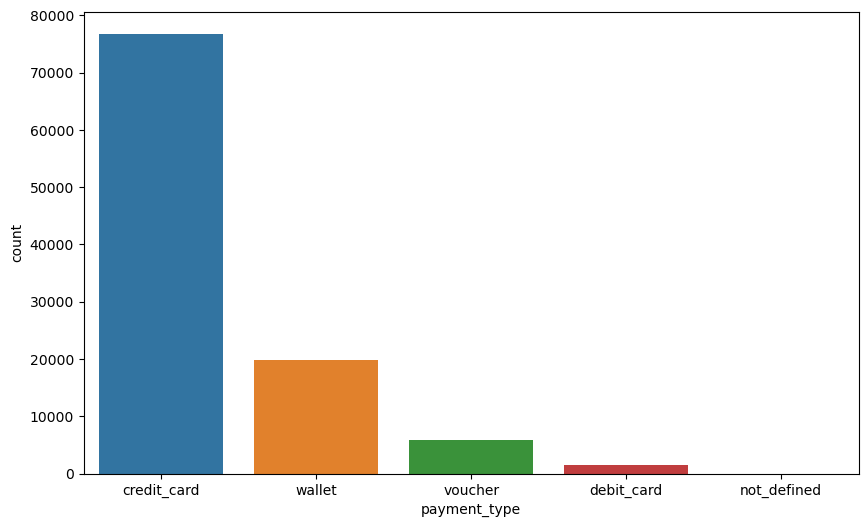

In [49]:
#Checking the most used 'payment_type' and their counts.
plt.figure(figsize=(10,6))
sns.countplot(data=payments_df, x=payments_df['payment_type'])
plt.show()

#### e. Dataset products_df

In [32]:
# Read products dataframe
products_df.head()

,product_id,product_category_name,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumery,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,art,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,sports_leisure,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,baby,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,housewares,625.0,20.0,17.0,13.0


In [33]:
# Check column info
products_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32951 entries, 0 to 32950
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   product_id             32951 non-null  object 
 1   product_category_name  32781 non-null  object 
 2   product_weight_g       32949 non-null  float64
 3   product_length_cm      32949 non-null  float64
 4   product_height_cm      32949 non-null  float64
 5   product_width_cm       32949 non-null  float64
dtypes: float64(4), object(2)
memory usage: 1.5+ MB


In [35]:
# Check for duplicate vaiue
products_df.duplicated().sum()

0

In [34]:
# Check for any missing value
products_df.isnull().sum()

product_id                 0
product_category_name    170
product_weight_g           2
product_length_cm          2
product_height_cm          2
product_width_cm           2
dtype: int64

we can remove the missing product_category_name, which is less than 1% (0.52%) of the total product_category_name.

In [36]:
# Removing the Null records
products_df = products_df.dropna()

In [37]:
# Check again for any missing value
products_df.isnull().sum()

product_id               0
product_category_name    0
product_weight_g         0
product_length_cm        0
product_height_cm        0
product_width_cm         0
dtype: int64

Our dataset is cleaned now

### Data exploration and Preparation for Market Basket Analysis

Active customer group for each month

In [38]:
# Number of active month when transcation happened.
orders_df['month_year']=orders_df['order_purchase_timestamp'].dt.to_period('M')
orders_df['month_year'].nunique()

23

There are total 23 months when transcation happened in the dataset.

In [39]:
# Active user count for each month.
month_cohort=orders_df.groupby('month_year')['customer_id'].nunique()
month_cohort

month_year
2016-09       1
2016-10     262
2016-12       1
2017-01     718
2017-02    1630
2017-03    2508
2017-04    2274
2017-05    3479
2017-06    3076
2017-07    3802
2017-08    4114
2017-09    4083
2017-10    4417
2017-11    7183
2017-12    5450
2018-01    6974
2018-02    6400
2018-03    6914
2018-04    6744
2018-05    6693
2018-06    6061
2018-07    6100
2018-08    6310
Freq: M, Name: customer_id, dtype: int64

Individual user count in entire 23 months, 2017-11 is the highest user count.

Text(0.5, 1.0, 'No. of active customers in each month')

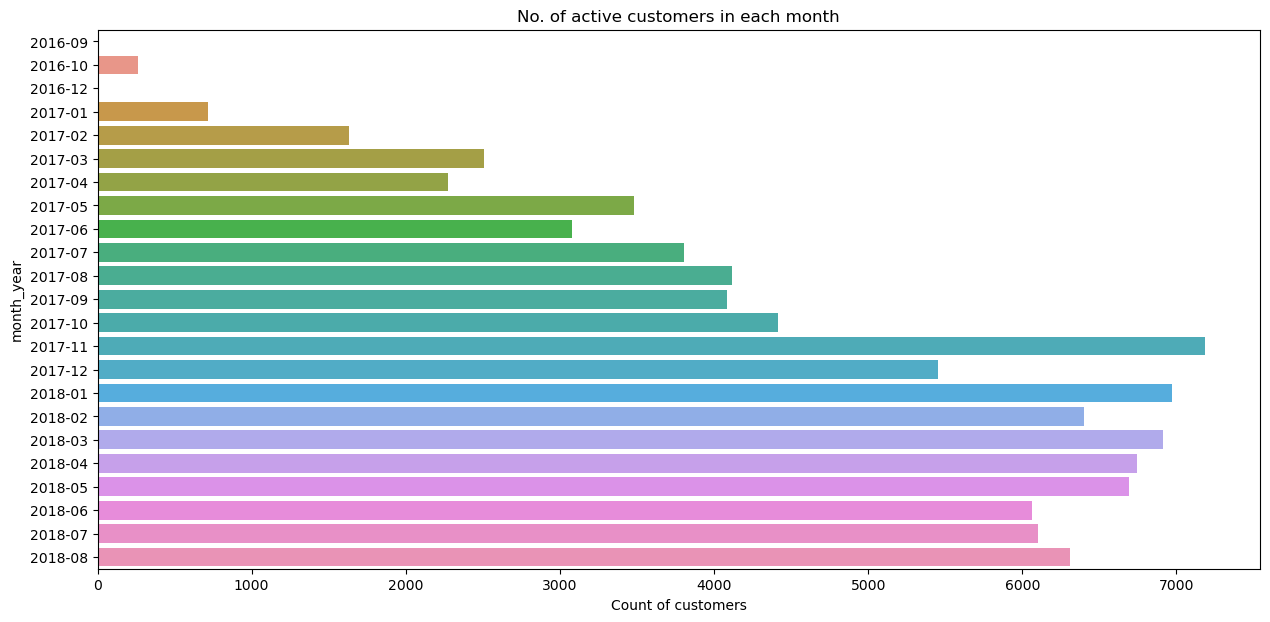

In [42]:
# Number of active customer in each month.
plt.figure(figsize=(15,7))
sns.barplot(y = month_cohort.index, x = month_cohort.values);
plt.xlabel("Count of customers")
plt.title("No. of active customers in each month")

In [44]:
# Number of active year when transcation happened.
orders_df['year']=orders_df['order_purchase_timestamp'].dt.to_period('Y')
orders_df['year'].nunique()

3

In [45]:
# Total number of transcation in each year.
year_cohort=orders_df.groupby('year')['customer_id'].nunique()
year_cohort

year
2016      264
2017    42136
2018    51612
Freq: A-DEC, Name: customer_id, dtype: int64

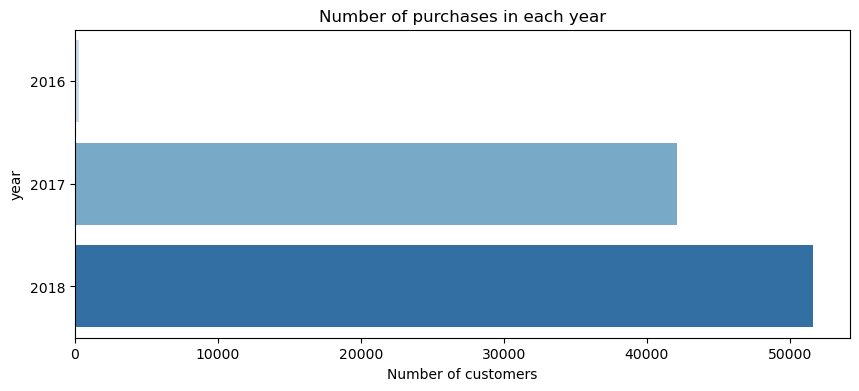

In [51]:
plt.figure(figsize=(10, 4))
sns.barplot(y=year_cohort.index, x=year_cohort.values, palette='Blues')  
plt.xlabel("Number of customers")
plt.title("Number of purchases in each year")
plt.show()

### Merging Dataset

In [52]:
retail_data = pd.merge(orders_df,order_items_df,how='inner', on='order_id')
retail_data = pd.merge(retail_data,products_df,how='inner', on='product_id')
retail_data = pd.merge(retail_data,payments_df,how='inner', on='order_id')
retail_data = pd.merge(retail_data,customers_df,how='inner', on='customer_id')

retail_data.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_timestamp,order_estimated_delivery_date,month_year,year,order_item_id,...,product_length_cm,product_height_cm,product_width_cm,payment_sequential,payment_type,payment_installments,payment_value,customer_zip_code_prefix,customer_city,customer_state
0,e481f51cbdc54678b7cc49136f2d6af7,7c396fd4830fd04220f754e42b4e5bff,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-10 21:25:13,2017-10-18,2017-10,2017,1,...,19.0,8.0,13.0,1,credit_card,1,18.12,3149,sao paulo,SP
1,e481f51cbdc54678b7cc49136f2d6af7,7c396fd4830fd04220f754e42b4e5bff,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-10 21:25:13,2017-10-18,2017-10,2017,1,...,19.0,8.0,13.0,3,voucher,1,2.00,3149,sao paulo,SP
2,e481f51cbdc54678b7cc49136f2d6af7,7c396fd4830fd04220f754e42b4e5bff,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-10 21:25:13,2017-10-18,2017-10,2017,1,...,19.0,8.0,13.0,2,voucher,1,18.59,3149,sao paulo,SP
3,69923a4e07ce446644394df37a710286,7c396fd4830fd04220f754e42b4e5bff,delivered,2017-09-04 11:26:38,2017-09-04 11:43:25,2017-09-05 19:20:20,2017-09-15,2017-09,2017,1,...,19.0,14.0,12.0,1,credit_card,1,44.11,3149,sao paulo,SP
4,128e10d95713541c87cd1a2e48201934,3a51803cc0d012c3b5dc8b7528cb05f7,delivered,2017-08-15 18:29:31,2017-08-15 20:05:16,2017-08-18 14:44:43,2017-08-28,2017-08,2017,1,...,19.0,8.0,13.0,1,credit_card,3,37.77,3366,sao paulo,SP


In [54]:
# Check column info
retail_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114605 entries, 0 to 114604
Data columns (total 26 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       114605 non-null  object        
 1   customer_id                    114605 non-null  object        
 2   order_status                   114605 non-null  object        
 3   order_purchase_timestamp       114605 non-null  datetime64[ns]
 4   order_approved_at              114605 non-null  datetime64[ns]
 5   order_delivered_timestamp      114605 non-null  datetime64[ns]
 6   order_estimated_delivery_date  114605 non-null  datetime64[ns]
 7   month_year                     114605 non-null  period[M]     
 8   year                           114605 non-null  period[A-DEC] 
 9   order_item_id                  114605 non-null  int64         
 10  product_id                     114605 non-null  object        
 11  

In [55]:
# Checking for any missing value
retail_data.isnull().sum()

order_id                         0
customer_id                      0
order_status                     0
order_purchase_timestamp         0
order_approved_at                0
order_delivered_timestamp        0
order_estimated_delivery_date    0
month_year                       0
year                             0
order_item_id                    0
product_id                       0
seller_id                        0
price                            0
shipping_charges                 0
product_category_name            0
product_weight_g                 0
product_length_cm                0
product_height_cm                0
product_width_cm                 0
payment_sequential               0
payment_type                     0
payment_installments             0
payment_value                    0
customer_zip_code_prefix         0
customer_city                    0
customer_state                   0
dtype: int64

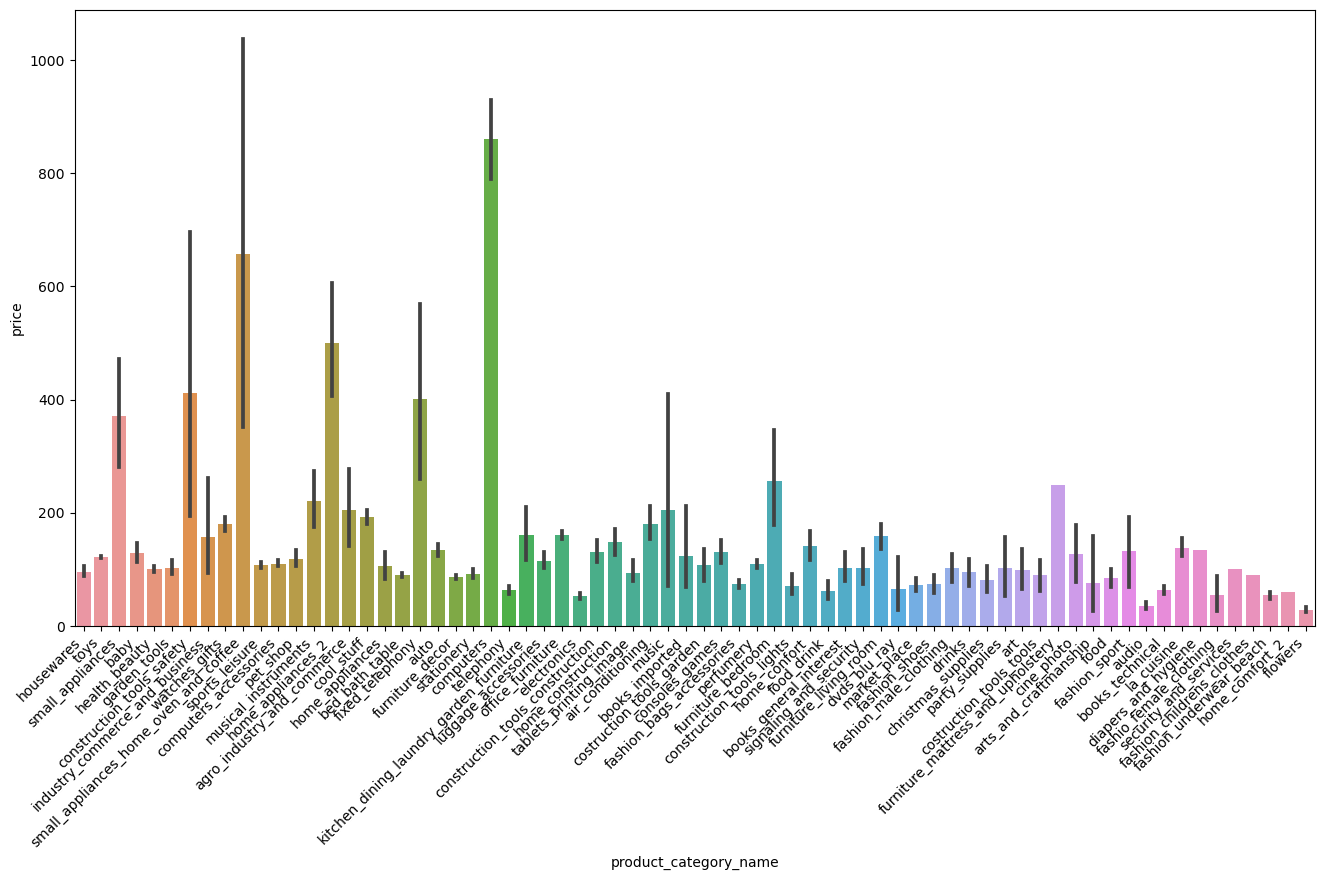

In [61]:
# See the price for each products.
plt.figure(figsize=(16, 8))
sns.barplot(x='product_category_name', y='price', data=retail_data)
plt.xticks(rotation=45, ha='right')
plt.show()

In [63]:
# Top 20 products as per total sales.
retail_data['total_sales'] = retail_data['price']  
top_products = retail_data.groupby('product_category_name')['total_sales'].sum().reset_index()
top_products = top_products.sort_values(by='total_sales', ascending=False)
top_20_products = top_products.head(20)
print(top_20_products)

    product_category_name  total_sales
68                   toys  10494792.47
42          health_beauty    304912.59
69          watches_gifts    280061.91
64         sports_leisure    249770.69
14  computers_accessories    243536.99
7          bed_bath_table    240952.78
19             cool_stuff    196621.55
38        furniture_decor    190853.05
48             housewares    164200.09
5                    auto    144999.78
56       office_furniture    112622.25
41           garden_tools    109117.44
6                    baby    101501.87
58              perfumery     93958.30
67              telephony     77803.11
59               pet_shop     61062.14
65             stationery     58390.58
13              computers     57662.59
62       small_appliances     57017.46
44      home_appliances_2     44441.64


Toys are the most sold product category.

In [75]:
# 20 Least sold products.
bottom_20_products = top_products.sort_values(by='total_sales', ascending=True).head(20)
print(bottom_20_products)

                product_category_name  total_sales
45                     home_comfort_2        59.90
60              security_and_services       100.00
22                diapers_and_hygiene       134.90
28          fashion_childrens_clothes       179.98
40  furniture_mattress_and_upholstery       249.00
26             fashio_female_clothing       271.19
34                            flowers       307.15
3               arts_and_craftmanship       379.80
31                      fashion_sport       526.65
51                         la_cuisine       687.98
12                         cine_photo       893.35
24                       dvds_blu_ray       911.35
32            fashion_underwear_beach      1137.30
57                     party_supplies      1221.59
2                                 art      1571.88
54                              music      1645.25
9                      books_imported      1976.98
11                 christmas_supplies      2257.83
29              fashion_male_cl

home_comfort_2 is the least sold porduct category.

In [65]:
# Top 20 products and Count the frequency of each product
product_frequency = retail_data['product_category_name'].value_counts().reset_index()
product_frequency.columns = ['product_category_name', 'frequency']
top_20_products_by_frequency = product_frequency.head(20)
print(top_20_products_by_frequency)

              product_category_name  frequency
0                              toys      86347
1                     health_beauty       3047
2                    bed_bath_table       2690
3                    sports_leisure       2332
4             computers_accessories       2209
5                   furniture_decor       2193
6                        housewares       1718
7                     watches_gifts       1555
8                         telephony       1229
9                              auto       1076
10                     garden_tools       1070
11                       cool_stuff       1020
12                        perfumery        856
13                             baby        788
14                      electronics        722
15                 office_furniture        702
16                       stationery        638
17                         pet_shop        513
18         fashion_bags_accessories        445
19  construction_tools_construction        254


Toys are the most frequently buying items.

In [76]:
# 20 least frequent products.
least_frequent_20_products = product_frequency.sort_values(by='frequency', ascending=True).head(20)
print(least_frequent_20_products)

                    product_category_name  frequency
69                         home_comfort_2          1
66                    diapers_and_hygiene          1
68      furniture_mattress_and_upholstery          1
67                  security_and_services          1
65              fashion_childrens_clothes          2
64                          fashion_sport          4
63                 fashio_female_clothing          5
62                             la_cuisine          5
61                  arts_and_craftmanship          5
60                             cine_photo          7
59                                  music          8
58                                flowers         11
57                         party_supplies         12
56                           dvds_blu_ray         14
55  small_appliances_home_oven_and_coffee         15
54                                    art         16
53                         books_imported         16
52                fashion_underwear_beach     

home_comfort_2 is the least frequently buying item.

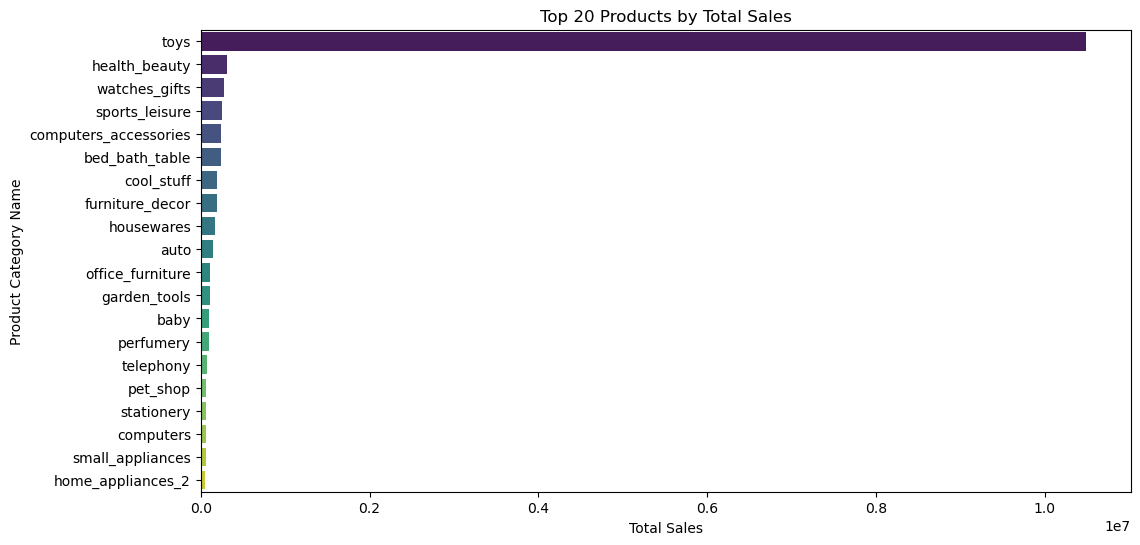

In [66]:
# Plotting the top 20 products by total sales
plt.figure(figsize=(12, 6))  
sns.barplot(x='total_sales', y='product_category_name', data=top_20_products, palette='viridis')
plt.xlabel('Total Sales')
plt.ylabel('Product Category Name')
plt.title('Top 20 Products by Total Sales')
plt.show()

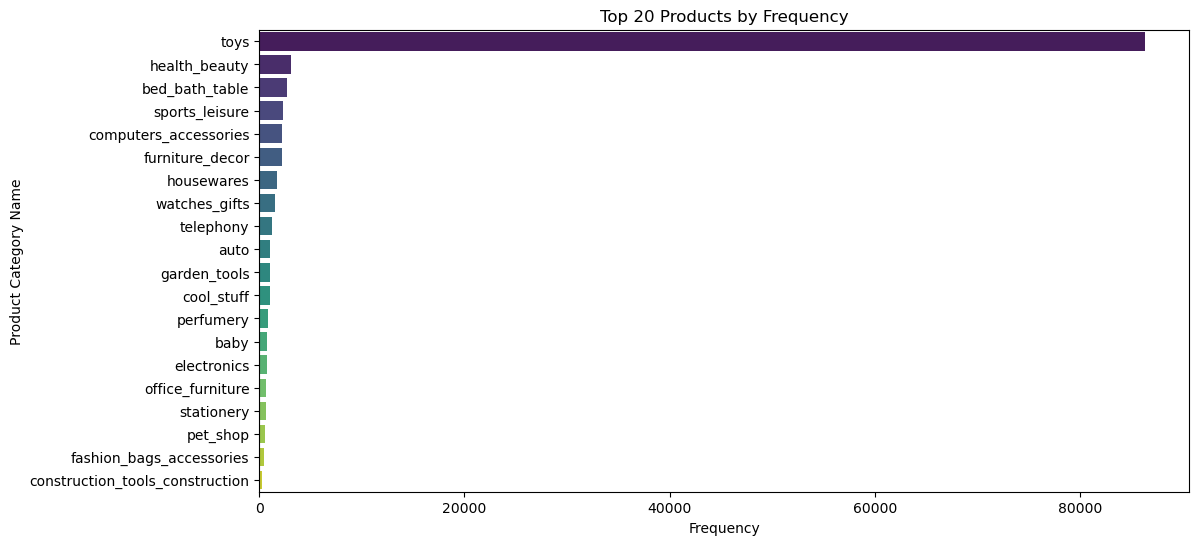

In [67]:
# Plotting the top 20 products by frequency
plt.figure(figsize=(12, 6))  
sns.barplot(x='frequency', y='product_category_name', data=top_20_products_by_frequency, palette='viridis')
plt.xlabel('Frequency')
plt.ylabel('Product Category Name')
plt.title('Top 20 Products by Frequency')
plt.show()

In [70]:
retail_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 114605 entries, 82186 to 101487
Data columns (total 27 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       114605 non-null  object        
 1   customer_id                    114605 non-null  object        
 2   order_status                   114605 non-null  object        
 3   order_purchase_timestamp       114605 non-null  datetime64[ns]
 4   order_approved_at              114605 non-null  datetime64[ns]
 5   order_delivered_timestamp      114605 non-null  datetime64[ns]
 6   order_estimated_delivery_date  114605 non-null  datetime64[ns]
 7   month_year                     114605 non-null  period[M]     
 8   year                           114605 non-null  period[A-DEC] 
 9   order_item_id                  114605 non-null  int64         
 10  product_id                     114605 non-null  object        
 11  s

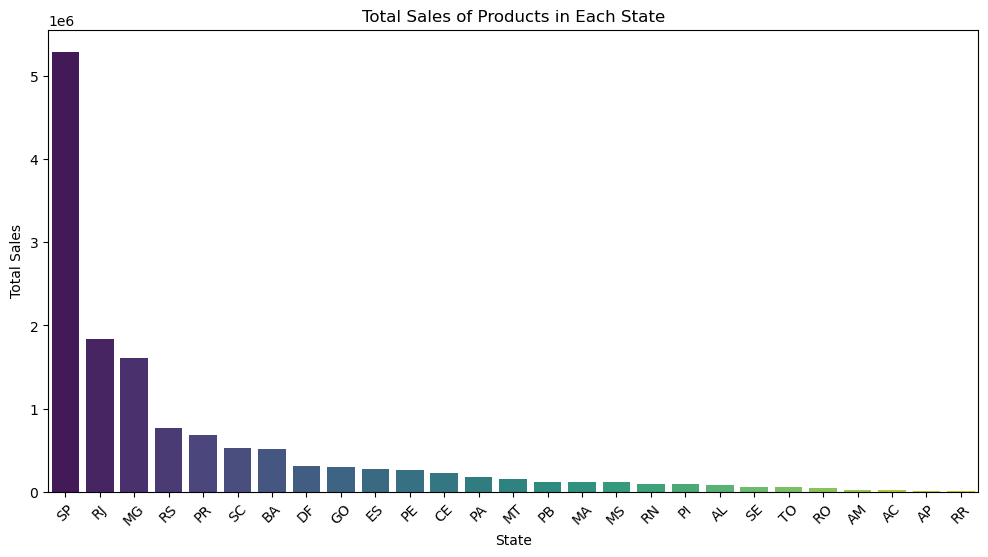

In [81]:
#  Total sales of products in each state.
sales_by_state = retail_data.groupby('customer_state')['total_sales'].sum().reset_index()
sales_by_state = sales_by_state.sort_values(by='total_sales', ascending=False)


plt.figure(figsize=(12, 6))  
sns.barplot(x='customer_state', y='total_sales', data=sales_by_state, palette='viridis')


plt.xlabel('State')
plt.ylabel('Total Sales')
plt.title('Total Sales of Products in Each State')
plt.xticks(rotation=45)  
plt.show()

Sao Paulo, Rio de Janeiro, and Minas Gerais are the states with the most total product sales.

### Exporting retail_data to Excel files

In [71]:
# Exporting.
retail_data.to_excel("retail_data.xlsx", index=False)

In [72]:
# Check the downloaded file path.
import os
os.getcwd()

'C:\\Users\\subhasish'